In [1]:
%matplotlib inline
import numpy as np
import scipy 
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from scipy import integrate
import itertools
import copy
import time

start_clock = time.time()

## Permutation Glass Simulation

We perform a Monte Carlo simulation of the permutation glass for gaussian, bernoulli, and uniform energy distributions and compare the simulated results to the theoretical results. 

----------

### Defining Distributions 

We consider three distributions each with mean $\lambda_0$ and standard deviation $\sigma_0$:

- **Gaussian**
$$
\rho_{0}(\lambda) = \frac{1}{\sqrt{2\pi \sigma_{0}^2}} e^{-(\lambda- \lambda_0)^2 /2\sigma_{0}^2},  
$$

- **Uniform**
$$
\rho_{0}(\lambda) = \frac{1}{2\sqrt{3}\sigma_{0}},
$$
for $\lambda_0 - \sigma_{0} \sqrt{3} \leq \lambda \leq \lambda_0 +\sigma_{0} \sqrt{3}$ and is zero otherwise,  


- **Symmetric-Bernoulli**
$$
\rho_{0}(\lambda) = q \delta(\lambda - \bar{\lambda}) + (1-q) \delta(\lambda+ \bar{\lambda}),
$$
where $q$ and $\bar{\lambda}$ are related to the mean $\lambda_0$ and standard deviation $\sigma_0$ through 
$$
\bar{\lambda} = \sqrt{\lambda_0^2  +\sigma_0^2}, \qquad q = \frac{1}{2} \left( 1 + \frac{\lambda_0}{\sqrt{\lambda_0^2 + \sigma_0^2}} \right).
$$

In [2]:
# Gaussian Distribution of Values 
lvec_gauss = lambda mu, sigma, nelem: np.random.normal(mu, sigma, nelem)

In [3]:
# Flat Distribution of Values
lvec_flat = lambda mu, sigma, nelem: np.random.uniform(mu - sigma*np.sqrt(3), mu+sigma*np.sqrt(3), nelem)

In [4]:
# Dirac Delta (Symmetric-Bernoulli) distribution of values

def lbar(mean, std):
    
    return np.sqrt(mean**2 + std**2)

def q(mean, std):

    return(0.5*(1 + mean/np.sqrt(mean**2 + std**2)))

lvec_dirac = lambda mu, sigma, nelem: np.random.binomial(1, q(mu, sigma), nelem)*2*lbar(mu, sigma)-lbar(mu, sigma)

In [5]:
## Test printing energy cost vectors for each distribution of values 

# mean and standard deviation of all distributions
mu, sigma = 1.0, .5 

# number of elements in the vector
nelem = 50

gauss_v = lvec_gauss(mu, sigma, nelem)
dirac_v = lvec_dirac(mu, sigma, nelem)
flat_v = lvec_flat(mu, sigma, nelem)

# standard deviation tests 
print("Gaussian Distribution STD:", np.std(gauss_v))
print("Bi-Dirac Distribution STD:", np.std(dirac_v))
print("Flat Distribution STD:", np.std(flat_v))

Gaussian Distribution STD: 0.4519627667476533
Bi-Dirac Distribution STD: 0.5310367218940703
Flat Distribution STD: 0.49130498647504295


### Theory definitions of partition function and $\langle j \rangle$

The partition function for the permutation glass is  

$$
Z_{N}(\{\beta \lambda_i\}) = \sum_{\vec{\theta} \in \text{Sym}(\omega)}\text{exp}\left[\beta  \sum_{i=1}^{N}\lambda_i I_{\theta_i \neq \omega_i} \right] =  \int^{\infty}_{0} ds\, e^{-s} \prod^{N}_{\ell=1}\Big( 1+ (s-1)e^{-\beta\lambda_{\ell}}\Big),
$$

and the average number of incorrectly ordered components can be shown to be

$$
\begin{align}
\langle j \rangle &= N - \frac{1}{Z_{N}(\{\beta \lambda_i\}) }\sum_{k=1}^NZ_{N-1}(\{\beta \lambda_i\}_{i \neq k}),
\end{align}
$$


where $Z_{N-1}(\{\beta \lambda_i\}_{i \neq k})$ is defined by the original partition function with the product taken over the $N-1$ elements of $\{\lambda_i\}$ not including $\lambda_k$.

In [6]:
#integrand of partition function 
f = lambda s, T, ls: np.exp(-s)*np.product( 1+ (s-1)*np.exp(-ls/T))

# partition function definition
ZN = lambda T, lvec: integrate.quad(f, 0, np.inf, args = (T, lvec), limit=1000)[0]

# testing
ZN(.76, gauss_v)

1.4245445908504356e+39

In [7]:
# product in <j> integrand

def jprod(s,  k , T, ls):
    
    lnew = np.delete(ls, k)
    
    # compute product of all elements except element k
    return(np.product( 1+ (s-1)*np.exp(-lnew/T)))


In [8]:
#Sum of Z_(N-1) functions

def ZN_1sum(T, ls):
    
    N = len(ls)
    
    func = 0
    for k in range(N):
        lnew = np.delete(ls, k)
        func = func + ZN(T, lnew)
        
    return(func)


In [9]:
# definition of <j>
avgj =lambda T, lvec: len(lvec)-ZN_1sum(T, lvec)/ZN(T, lvec)

# test of value
avgj(1.0, gauss_v)

47.23510075973761

### Case where $\sigma_0 = 0$ (no disorder)

For the case when there is no disorder, the average number of incorrect components reduces to

$$ \langle j \rangle = N - e^{\beta \lambda_0},$$

for all distributions. 


In [10]:
### function to test low standard deviation values 

# simple zero-disorder order parameter computed from laplace method

def j_funcsimp(y0, N, T):
    
    u = y0/T
    
    if T> y0/np.log(N):
        
        return N - np.exp(y0/T)
    
    else: 
        
        return 0.0
    
j_funcsimp = np.vectorize(j_funcsimp)

### Collecting Theoretical Results

Here we collect the theoretical results for $\langle j \rangle$ for each of the above three distributions for $(\mu, \sigma_0) = (1.0, 0.35)$ and $(\mu, \sigma_0) = (1.0, 1.5)$ for $N = 50$. 

In [11]:
# mean and standard deviation of all distributions
mu = 1.0

# number of elements in the vector
nelem = 50

In [12]:
# Gaussian Distribution of Values 
lvec_gauss = lambda mu, sigma, nelem: np.random.normal(mu, sigma, nelem)

# Dirac Delta distribution of values
lvec_dirac = lambda mu, sigma, nelem: np.random.binomial(1, q(mu, sigma), nelem)*2*lbar(mu, sigma) - lbar(mu, sigma)

# Flat Distribution of Values
lvec_flat = lambda mu, sigma, nelem: np.random.uniform(mu - sigma*np.sqrt(3), mu+sigma*np.sqrt(3), nelem)

In [13]:
## Gaussian theoretical results

lvec_g_cut = lvec_gauss(mu, 0.35, nelem)
lvec_g_high = lvec_gauss(mu, 1.5, nelem)

# spectrum of temperature values
temp_vals = np.linspace(.01, 1.3, 100)

jvals_g_high = np.zeros(len(temp_vals)) # initialize an empty vector
jvals_g_cut = np.zeros(len(temp_vals)) # initialize an empty vector
for k in range(len(temp_vals)):   # fill vector with values at each temperature 
    jvals_g_high[k] = avgj(temp_vals[k], lvec_g_high);
    jvals_g_cut[k] = avgj(temp_vals[k], lvec_g_cut);

/Users/mobolajiwilliams/opt/miniconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
<ipython-input-6-0f3a5085b5af>:5: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  ZN = lambda T, lvec: integrate.quad(f, 0, np.inf, args = (T, lvec), limit=1000)[0]


In [14]:
## Symmetric Bernoulli theoretical results

lvec_d_cut = lvec_dirac(mu, .35, nelem)
lvec_d_high = lvec_dirac(mu, 1.5, nelem)

# spectrum of temperature values
temp_vals = np.linspace(.01, 1.3, 100)

jvals_d_cut = np.zeros(len(temp_vals)) # initialize an empty vector
jvals_d_high = np.zeros(len(temp_vals)) # initialize an empty vector
for k in range(len(temp_vals)):   # fill vector with values at each temperature
    jvals_d_cut[k] = avgj(temp_vals[k], lvec_d_cut)
    jvals_d_high[k] = avgj(temp_vals[k], lvec_d_high)


<ipython-input-6-0f3a5085b5af>:5: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  ZN = lambda T, lvec: integrate.quad(f, 0, np.inf, args = (T, lvec), limit=1000)[0]
<ipython-input-6-0f3a5085b5af>:2: RuntimeWarning: invalid value encountered in double_scalars
  f = lambda s, T, ls: np.exp(-s)*np.product( 1+ (s-1)*np.exp(-ls/T))


In [15]:
## Uniform theoretical results

lvec_f_cut = lvec_flat(mu, .35, nelem)
lvec_f_high = lvec_flat(mu, 1.5, nelem)

# spectrum of temperature values
temp_vals = np.linspace(.01, 1.3, 100)

jvals_f_cut = np.zeros(len(temp_vals)) # initialize an empty vector
jvals_f_high = np.zeros(len(temp_vals)) # initialize an empty vector
for k in range(len(temp_vals)):   # fill vector with values at each temperature
    jvals_f_cut[k] = avgj(temp_vals[k], lvec_f_cut)
    jvals_f_high[k] = avgj(temp_vals[k], lvec_f_high)

<ipython-input-6-0f3a5085b5af>:5: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  ZN = lambda T, lvec: integrate.quad(f, 0, np.inf, args = (T, lvec), limit=1000)[0]


### Monte Carlo Simulation Code

In this section, we define the code to simulate the permutation glass given an energy cost distribution.

In [16]:
# List of favorable contacts 
# order doesn't matter so we include reversed elements as well 

Ncomp = 50

omega0 = [0]*Ncomp
for k in range(Ncomp):
    omega0[k] = k

In [17]:
# checking values of omega
print(omega0)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]


In [18]:
## Hamiltonian function 

def Ham(lvec, ls, Ncomp):
    
    N = int(Ncomp)
    energy = 0
    
    for k in range(N):
        
        # there is an energy cost if ls[k] doesn't equal omega0[k]
        
        if ls[k] != omega0[k]:       
            energy = energy + lvec[k]
            
    return energy   

## transition operator
def trans(init_ls):
    
    i1 = int(np.random.choice(range(Ncomp)))
    i2 = int(np.random.choice(range(Ncomp)))

    ## new omega vector 
    fin_ls = copy.deepcopy(init_ls)
    fin_ls[i2] = init_ls[i1]
    fin_ls[i1] = init_ls[i2]
    
    return(fin_ls)

## Defining Boltzmann Weight
def Boltz(lvec, ls, T, Ncomp):
            
    return np.exp(-Ham(lvec, ls, Ncomp)*1.0/T)

## number of favorable contacts; normalized
def j(ls, Ncomp):
    
    N = int(Ncomp)
    num = 0
    
    for k in range(N):
        
        if ls[k] != omega0[k]:
            num = num+1
            
    return num

In [19]:
### Metropolis Monte Carlo Algorithm 

## loads uniform random sampling 
runif = np.random.rand

def met_permglass(n_iter, initial_state, lamb, temp, Ncomp):
    '''
    #################################################################
    # function to sample using Metropolis 
    #  
    # n_iter:  number of iterations
    # initial_state: initial state for the start position for our chain
    # gamma: energy cost for incorrect component
    # temp: temperature 
    ##################################################################
    '''
    # Initialize trace for state values
    state_vals = [0]*(n_iter+1)
    
    # Set initial values
    state_vals[0] = initial_state
        
    #sets current log-probability
    #current_prob = prob_d(T[0], lamb) 
    log_current_prob = np.log(Boltz(lamb, state_vals[0], temp, Ncomp))
        
    # Initialize acceptance counts
    # We can use this to tune our step size
    accepted = 0
    
    for i in range(n_iter):
    
        # get current permutation
        current_state = state_vals[i]
        
        # proposed new permutation; generated from random integer sampling
        new_state = trans(current_state)
        
        # Calculate posterior log-probability with proposed value
        log_proposed_prob = np.log(Boltz(lamb, new_state, temp, Ncomp)) 

        # Log-acceptance rate
        log_alpha = log_proposed_prob- log_current_prob

        # Sample a uniform random variate
        u = runif()

        # Test proposed value
        if np.log(u) < log_alpha:
            # Accept
            state_vals[i+1] = new_state
            log_current_prob = log_proposed_prob
            accepted += 1
        else:
            # Stay put
            state_vals[i+1] = state_vals[i]

    # return our samples and the number of accepted steps
    return state_vals, accepted

In [20]:
## average number of incorrect contacts across all states in ensemble

## we start far from the beginning of the chain to ensure that it
## has reached "equilibrium"

def avg_j(state_vals, Nmc, Ncomp):
    
    length = int(Nmc/50)
    
    ls = [0]*length
    ls = np.array(ls)
    for k in range(length):
        ls[k] = j(state_vals[Nmc-length+k], Ncomp)
    
    
    return(np.mean(ls))

In [21]:
## standard deviation of number of incorrect components across all states in ensemble

## we start far from the beginning of the chain to ensure that it
## has reached "equilibrium"

def std_j(state_vals, Nmc, Ncomp):
    
    length = int(Nmc/50)
    
    ls = [0]*length
    ls = np.array(ls)
    for k in range(length):
        ls[k] = j(state_vals[Nmc-length+k], Ncomp)
    
    
    return(np.std(ls))

### Predicted (Inverse) Transition Temperatures

Each distribution has a predicted temperature at which the system settles into the completely correct configuration $\langle j \rangle =0$. These (inverse) temperatures are 

- For gaussian distribution: 

$$
\beta_c = \frac{\lambda_0}{\sigma_{0}^2} \left( 1 - \sqrt{1 - \frac{2\sigma_{0}^2}{\lambda_{0}^2} \ln N}\,\right).
$$

- For uniform distribution: 
$$
\beta_c \simeq \frac{1}{\lambda_0 - \sigma_0 \sqrt{3}} W_{0} \left(\frac{N}{2\sigma_{0}\sqrt{3}}(\lambda_0 - \sigma_0 \sqrt{3}) \right),
$$

where $W_0$ is the principal branch of the Lambert W function, and this is an approximate result valid for large $\sigma_0$. 




- For symmetric-Bernoulli (or bi-Dirac) distribution: 
$$
\beta_c \bar{\lambda} = \ln \left[ \frac{1}{2N(1-q)} \left( 1 - \sqrt{1- 4N^2 q (1-q)}\right) \right].
$$


In [22]:
### Gaussian ###
betac_gauss = lambda avg_l, std_l, N: (avg_l/(std_l)**2)*(1- np.sqrt(1- 2.0*(std_l**2/(avg_l**2))*np.log(N)  ))


### Uniform (for large sigma) ### 
betac_flat = lambda avg_l, std_l, N: np.real(1.0/(avg_l-np.sqrt(3)*std_l)*scipy.special.lambertw(N*(avg_l-np.sqrt(3)*std_l)/(2*std_l*np.sqrt(3)) ))


### Dirac ###
betac_dirac = lambda avg_l, std_l, N: (1.0/np.sqrt(avg_l**2 + std_l**2))*np.log((1-avg_l/np.sqrt(std_l**2+avg_l**2))**(-1)*(1-np.sqrt(1-N**2*std_l**2/(std_l**2+avg_l**2 )))/N)

------

**Aside:**

For uniform distribution, the *exact* transition temperature is found by solving 

$$
-\beta_c \lambda_0+\ln \left[\frac{\sinh(\beta_c \sigma_{0}\sqrt{3})}{\beta_c \sigma_{0}\sqrt{3}}\right] + \ln N = 0,  $$

but the resulting temperature is close enough to the value given by $\beta_c$ above that we can use the above result as a reasonable approximation. 

In [23]:
'''
Equation solver for finding exact temperature for the uniform distribution
'''

## Constraint function ##
func_flat = lambda beta_c, avg_l, std_l, N: beta_c*avg_l- np.log(N*np.sinh(beta_c*std_l*np.sqrt(3))/(beta_c*std_l*np.sqrt(3)))

## Solving the constraint for beta ##
def flat_solver2(mean_l, sig_l, N):
    
    func_reduced = lambda beta_c: func_flat(beta_c, mean_l, sig_l, N)
    
    beta_guess = np.log(N)/mean_l
    
    beta_soln = fsolve(func_reduced, beta_guess)
    
    return(beta_soln[0])

flat_solver2 = np.vectorize(flat_solver2)

In [24]:
# checking relative error of approximation for intermediate variance

np.abs(flat_solver2(1.0, .35, 50) - betac_flat(1.0, .35, 50))/flat_solver2(1.0, .35, 50)

0.0005716911368662681

---------

### Main Theory vs. Simulation Plots

With the previous code we can now, reproduce the theory vs simulation plots for each distribution. 

#### Gaussian Simulation

In [25]:
# number of samples
Nmc = 20000

# number of joining contacts
Ncomp = 50
## zeroth state function 
omega0 = [0]*Ncomp
for k in range(Ncomp):
    omega0[k] = k

npoints = 30
temp_vals = np.linspace(.01, 1.3, npoints).tolist()
j_vals_g = [0]*npoints
std_vals_g = [0]*npoints
for k in range(npoints):
    # make copy of list 
    omega_cpy = copy.deepcopy(omega0)

    # metroplois generator
    states_list, accepted = met_permglass(Nmc, omega_cpy, lvec_g_cut, temp_vals[k], Ncomp)
    
    j_vals_g[k] = avg_j(states_list, Nmc, Ncomp)
    std_vals_g[k] = std_j(states_list, Nmc, Ncomp)

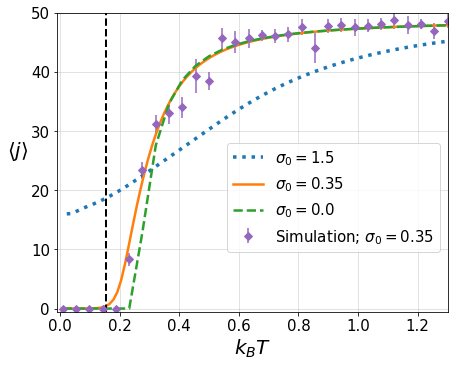

In [26]:
plt.figure(figsize = (7,5.5))

# spectrum of temperature values
temp_vals100 = np.linspace(.01, 1.3, 100)

# plots 
plt.plot(temp_vals100, jvals_g_high, label = r'$\sigma_0 = 1.5$', linestyle = ':', linewidth = 3.5) # plot partition function for distribution of values 
plt.plot(temp_vals100, jvals_g_cut, label = r'$\sigma_0 = 0.35$', linewidth = 2.5) # plot partition function for  distribution of values 
plt.plot(temp_vals, j_funcsimp(mu, nelem, temp_vals), label = r'$\sigma_0 = 0.0$', linewidth = 2.5, linestyle = 'dashed') # plot partition function with energy cost given by mean
plt.axvline(x=1/betac_gauss(1.0, .35, nelem), color = 'k', linestyle='dashed', linewidth = 2.0)
plt.errorbar(temp_vals,j_vals_g, yerr=std_vals_g, fmt='C4D',label = r'Simulation; $\sigma_0 = 0.35$', markersize = 5.5 )

# plot formatting
plt.xlabel(r'$k_B T$', fontsize = 20)
plt.xlim([-0.01,1.3])
plt.ylim([-.5,50])
plt.ylabel(r'$\langle j \rangle$', fontsize = 20, rotation=0)
ax = plt.gca()
ax.yaxis.set_label_coords(-0.1,.5)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.legend(bbox_to_anchor = (1.0,.59), fontsize = 15)
plt.grid(alpha = 0.45)

# plt.savefig('avg_j_gauss_N50.png',bbox_inches='tight')

plt.show()

#### Symmetric Bernoulli

In [27]:
## Generate lf for each temperature from .03 to 2.0 in npoints steps


# number of samples
Nmc = 20000

# number of joining contacts
Ncomp = 50
## zeroth state function 
omega0 = [0]*Ncomp
for k in range(Ncomp):
    omega0[k] = k

npoints = 30
temp_vals = np.linspace(.01, 1.3, npoints).tolist()
j_vals_d = [0]*npoints
std_vals_d = [0]*npoints
for k in range(npoints):
    # make copy of list 
    omega_cpy = copy.deepcopy(omega0)

    # metroplois generator
    states_list, accepted = met_permglass(Nmc, omega_cpy, lvec_d_cut, temp_vals[k], Ncomp)
    
    j_vals_d[k] = avg_j(states_list, Nmc, Ncomp)
    std_vals_d[k] = std_j(states_list, Nmc, Ncomp)

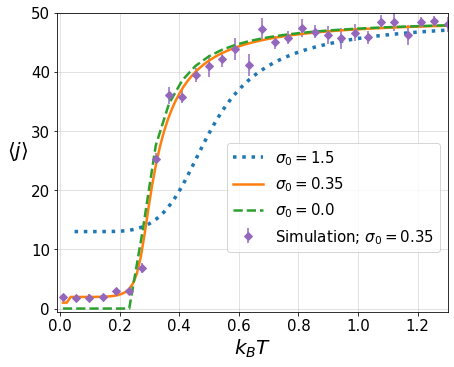

In [28]:
plt.figure(figsize = (7,5.5))

# spectrum of temperature values
temp_vals100 = np.linspace(.01, 1.3, 100)

# plots 
plt.plot(temp_vals100, jvals_d_high, label = r'$\sigma_0 = 1.5$', linestyle = ':', linewidth = 3.5) # plot partition function for distribution of values 
plt.plot(temp_vals100, jvals_d_cut, label = r'$\sigma_0 = 0.35$', linewidth = 2.5) # plot partition function for  distribution of values 
plt.plot(temp_vals, j_funcsimp(mu, nelem, temp_vals), label = r'$\sigma_0 = 0.0$', linewidth = 2.5, linestyle = 'dashed') # plot partition function with energy cost given by mean
plt.errorbar(temp_vals,j_vals_d, yerr=std_vals_d, fmt='C4D',label = r'Simulation; $\sigma_0 = 0.35$', markersize = 5.5 )

# plot formatting
plt.xlabel(r'$k_B T$', fontsize = 20)
plt.xlim([-0.01,1.3])
plt.ylim([-.5,50])
plt.ylabel(r'$\langle j \rangle$', fontsize = 20, rotation=0)
ax = plt.gca()
ax.yaxis.set_label_coords(-0.1,.5)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.legend(bbox_to_anchor = (1.0,.59), fontsize = 15)
plt.grid(alpha = 0.45)

# plt.savefig('avg_j_dirac_N50.png',bbox_inches='tight')

plt.show()

#### Uniform Distribution

In [29]:
## Generate lf for each temperature from .03 to 2.0 in npoints steps


# number of samples
Nmc = 20000

# number of joining contacts
Ncomp = 50
## zeroth state function 
omega0 = [0]*Ncomp
for k in range(Ncomp):
    omega0[k] = k

npoints = 30
temp_vals = np.linspace(.01, 1.3, npoints).tolist()
j_vals_f = [0]*npoints
std_vals_f = [0]*npoints
for k in range(npoints):
    # make copy of list 
    omega_cpy = copy.deepcopy(omega0)

    # metroplois generator
    states_list, accepted = met_permglass(Nmc, omega_cpy, lvec_f_cut, temp_vals[k], Ncomp)
    
    j_vals_f[k] = avg_j(states_list, Nmc, Ncomp)
    std_vals_f[k] = std_j(states_list, Nmc, Ncomp)

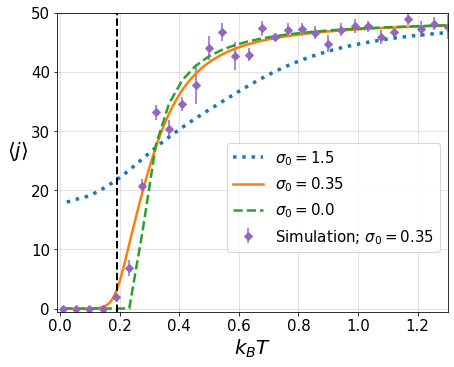

In [30]:
#matplotlib.style.use('default')
plt.figure(figsize = (7,5.5))

# spectrum of temperature values
temp_vals100 = np.linspace(.01, 1.3, 100)

# plots 
plt.plot(temp_vals100, jvals_f_high, label = r'$\sigma_0 = 1.5$', linestyle = ':', linewidth = 3.5) # plot partition function for distribution of values 
plt.plot(temp_vals100, jvals_f_cut, label = r'$\sigma_0 = 0.35$', linewidth = 2.5) # plot partition function for  distribution of values 
plt.plot(temp_vals, j_funcsimp(mu, nelem, temp_vals), label = r'$\sigma_0 = 0.0$', linewidth = 2.5, linestyle = 'dashed') # plot partition function with energy cost given by mean
plt.axvline(x=1/betac_flat(1.0, 0.35, nelem), color = 'k', linestyle='dashed', linewidth = 2.0)
plt.errorbar(temp_vals,j_vals_f, yerr=std_vals_f, fmt='C4D',label = r'Simulation; $\sigma_0 = 0.35$', markersize = 5.5 )

# plot formatting
plt.xlabel(r'$k_B T$', fontsize = 20)
plt.xlim([-0.01,1.3])
plt.ylim([-.5,50])
plt.ylabel(r'$\langle j \rangle$', fontsize = 20, rotation=0)
ax = plt.gca()
ax.yaxis.set_label_coords(-0.1,.5)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.legend(bbox_to_anchor = (1.0,.59), fontsize = 15)
plt.grid(alpha = 0.45)

# plt.savefig('avg_j_flat_N50.png',bbox_inches='tight')

plt.show()

In [31]:
print('Elapsed Time: %.3f min' % ((time.time()-start_clock)/60))

Elapsed Time: 3.951 min
